In [1]:
#include <iostream>
#include <xtensor/xarray.hpp>
#include <xtensor/xio.hpp>
#include <xtensor/xview.hpp>
#include <xtensor/xarray.hpp>
#include <xtensor/xfixed.hpp>
#include <xtensor/xio.hpp>
#include <xtensor/xtensor.hpp>
#include <xtensor/xadapt.hpp>
#include <xtensor/xarray.hpp>
#include <xtensor/xaxis_slice_iterator.hpp>
#include <xtensor/xaxis_iterator.hpp>
#include <xtensor/xio.hpp>
#include <xtensor/xarray.hpp>
#include <xtensor/xindex_view.hpp>
#include <xtensor/xchunked_array.hpp>
#include <xtensor/xfixed.hpp>
#include <cstddef>
#include <vector>
#include <xtensor/xarray.hpp>
#include <xtensor/xadapt.hpp>
#include <istream>
#include <fstream>
#include <iostream>
#include <xtensor/xarray.hpp>
#include <xtensor/xcsv.hpp>
#include <iostream>
#include <fstream>
#include <functional>
#include <cstdio>
#include <xtensor/xcsv.hpp>
#include <xcpp/xdisplay.hpp>
#include <xtensor/xsort.hpp>

using namespace xt;
using namespace xt::placeholders;  // to enable _ syntax

#include <iostream>
#include <fstream>
using namespace std;

# DBSCANRN

# Load data

In [2]:
ifstream input_file;
input_file.open ("../data/lecture_dataset.txt");
auto data = load_csv<double>(input_file);
input_file.close();

data.reshape(data.shape());
xarray<double> X = view(data, all(), range(0, 2));

# Similarity



In [3]:
float cosine_dissimilarity(const xarray<double>& a, const xarray<double>& b){ 
    auto numerator = sum(a * b);
    auto denominator = sqrt(sum(pow(a, 2))) * sqrt(sum(pow(b, 2)));
    auto result = numerator / denominator;
    return 1 - result(0);
}

# Normalization

In [4]:
auto normalize(const xarray<double>& a){ 
    xarray<double> result = a / sqrt(sum(pow(a, 2)));
    return result;
}

# Clusterization

In [5]:
auto dbscanrn_opt(const xarray<float>& X_original, int k)
{
    // normalization
    xarray<float> X = normalize(X_original);

    // each data point can be in one of 3 stages
    int NOT_VISITED = -1; // not visited point
    int VISITED = 0; // non-core point
    int CLUSTERED = 1; // core point

    // initial setup
    int n = X.shape()[0];
    xarray<double> cluster = ones<double>({n}) * -1; // cluster register
    xarray<double> state = ones<double>({n}) * NOT_VISITED; // state register
    int cluster_id = 1;
    xarray<int> all_point_indices = arange(n);
    map<int, vector<int>> point_rnn;
    map<int, xarray<int>> point_knn;
    
    xarray<int> all_point_sorted; 
    xarray<int> candidates;
    float real_max; 
    xarray<double> pessimistic_estimation;
    xarray<double> candidate_distance;
    int down_row;
            
    function < void( int ) > calc_pessimistic_estimation = [&] (
        int current_index 
    ) -> void {
        // choosing the next point to check if he is a better neighbor
        int new_candidate = all_point_sorted(down_row);
        bool previous_check = pessimistic_estimation(down_row) < real_max;
        down_row++;
        if (!previous_check) {
            point_knn[(int) current_index] = candidates;
            return;
        };
        if (previous_check) {
            float similarity = cosine_dissimilarity(
                new_candidate, all_point_sorted[current_index]
            );
            if (similarity < real_max) {
                candidates = filter(candidates, not_equal(candidate_distance, real_max));
                candidates = concatenate(xtuple(candidates, xarray<int>{new_candidate}));
                candidate_distance = concatenate(xtuple(candidate_distance, xarray<double>{similarity}));
                real_max = amax(candidate_distance)(0);
                calc_pessimistic_estimation((int) current_index);
            };
        };
        calc_pessimistic_estimation((int) current_index);   
    };

    auto get_tiknn = [&] (int current_index, xarray<int> neighbor_indices, int k){
        vector<double> r_dist;
        for (auto& idx : all_point_indices) {
            r_dist.push_back(cosine_dissimilarity(row(X, idx), {0, 1}));
        };
        xarray<double> r_distance = adapt(r_dist, {r_dist.size()});
        auto current_index_r_distance = r_distance[current_index];
        pessimistic_estimation = abs(current_index_r_distance - r_distance);
        xarray<int> sort_indices = argsort(pessimistic_estimation);
        all_point_sorted = index_view(all_point_indices, sort_indices); // df 
        
        // selecting candidates for k - nearest neighbors
        candidates = view(all_point_sorted, range(1, k+1)); //dfx
        down_row = k + 2;
                
        // calculation of similarity for candidates
        vector<double> dist;
        for (auto& candidate_idx : candidates) {
            dist.push_back(cosine_dissimilarity(row(X, current_index), row(X, candidate_idx)));
        }
        candidate_distance = adapt(dist, {dist.size()});
        real_max = amax(candidate_distance)(0);
        calc_pessimistic_estimation((int) current_index);
    };  
        
    auto get_knn = [&] (int current_index, xarray<int> neighbor_indices, int k){
        vector<float> neighbor_sim;
        for (auto& neighbor_index : neighbor_indices) {
            neighbor_sim.push_back(cosine_dissimilarity(row(X, neighbor_index), row(X, current_index)));
        };
        xarray<float> neighbor_similaritys = adapt(neighbor_sim, {neighbor_sim.size()});
        xarray<int> sort_indices = argsort(neighbor_similaritys);
        xarray<int> neighbor_indices_sorted = index_view(neighbor_indices, sort_indices); 
        point_knn[(int) current_index] = view(neighbor_indices_sorted, range(0, k));  
    };    
    
    auto get_pointwise_rnn = [&] (int current_index){
        vector<int> rnn;
        for (auto& neighbor_index : point_knn[(int) current_index]) {
            if ((point_knn[(int) neighbor_index], (int) current_index)) {
                rnn.push_back((int) neighbor_index);
            };
        };
        point_rnn[(int) current_index] = rnn;
    };
    
    auto get_rnn = [&] (){
        for (int current_index = 0; current_index < n; current_index++) {
            // remove current index from neighbors
            xarray<int> neighbor_indices = col(
                from_indices(argwhere(not_equal(all_point_indices, current_index))), 0
            );
            get_tiknn((int) current_index, neighbor_indices, k);
        };
        for (int current_index =  0; current_index < n; current_index++) {
            get_pointwise_rnn((int) current_index);
        };
    };

    // extend cluster
    function < void( int ) > search = [&] (int current_index) -> void {
        if (point_rnn[(int) current_index].size() <  k) {
            state[(int) current_index] = VISITED;
        } else {
            state[(int) current_index] = CLUSTERED;
            cluster[(int) current_index] = cluster_id;
            for (auto& neighbor_index : point_rnn[(int) current_index]) {
                if (state[(int) neighbor_index] == NOT_VISITED) {
                    search(neighbor_index);
                };
                state[(int) neighbor_index] = CLUSTERED;
                cluster[(int) neighbor_index] = cluster_id;
            };
        };
    };
    
    get_rnn();
    
    // visit all points
    while (any(equal(state, NOT_VISITED))){
        xarray<int> idx = from_indices(argwhere(equal(state, NOT_VISITED)));
        search(idx(0,0));
        cluster_id++;
    }

    // clusterize all outlier points to nearest cluster 
    while (any(equal(state, VISITED))){
        xarray<int> idx_not_clustered = from_indices(argwhere(equal(state, VISITED)));
        xarray<int> idx_clustered = from_indices(argwhere(equal(state, CLUSTERED)));
        get_knn((int) idx_not_clustered(0,0), idx_clustered, 1);
        auto closest_clustered_idx = point_knn[(int) idx_not_clustered(0,0)](0);
        cluster[(int) idx_not_clustered(0,0)] = cluster[(int) closest_clustered_idx];
        state[(int) idx_not_clustered(0,0)] = CLUSTERED;
    }
    return cluster;
}

auto y_pred = dbscanrn_opt(X, 4);
y_pred

2.
2.
2.
3.
3.
2.
2.
2.
3.
3.
3.


# Save output to csv

In [6]:
ofstream out_file;
out_file.open("../out/dbscanrn_opt_cpp_lecture_dataset.csv");
dump_csv(out_file, view(y_pred, all(), newaxis()));
out_file.close();

# To execute following cells change kernel into python 

In [1]:
cd ..

/work


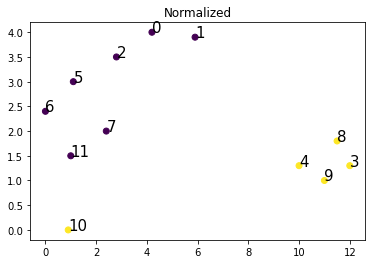

In [2]:
import pandas as pd
from src.datasets import Dataset
from src.utils import *

dataset = Dataset('./data/lecture_dataset.txt')
X, y = dataset.X, dataset.y
c = pd.read_csv("./out/Cpp_out_dbscanrn_opt_lecture_dataset.csv", header=None)
display_points(X, c, 'Normalized', numerate=True)